In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('CharAtbMax.csv')

In [12]:
df.head()

,Personagem,Level,Arma,HP,ATK,DEF,SPAtrib,Atributo,TaxaCrit,Dano+DanoCritico
0,Amber,90,Arco,9461,223,601,0.240,%ATK,0.05,1.5
1,Barbara,90,Catalisador,9787,159,669,0.240,%Vida,0.05,1.5
2,Beidou,90,Espadão,13050,225,648,0.240,%DanoElectro,0.05,1.5
3,Bennett,90,Espada,12397,191,771,0.267,%RecargaEnergia,0.05,1.5
4,Chongyun,90,Espadão,10984,223,648,0.240,%ATK,0.05,1.5


## Cleanup
I spent some time cleaning up the column names to terms that I could read easier. This involved translating some words to English and abbreviating some terms `Bonus -> +`

I also created a separate DataFrame for looking at my columns of interest. The dataset is rather small in total (410) so it wasn't too important to do with this set.

In [13]:
# Renaming columns 
df.columns = ["Name", "Level", "Weapon", "HP", "ATK", "DEF", "SPAtrib", "Attribute", "Crit", "Dmg+Crit"]

In [14]:
df.head()

,Name,Level,Weapon,HP,ATK,DEF,SPAtrib,Attribute,Crit,Dmg+Crit
0,Amber,90,Arco,9461,223,601,0.240,%ATK,0.05,1.5
1,Barbara,90,Catalisador,9787,159,669,0.240,%Vida,0.05,1.5
2,Beidou,90,Espadão,13050,225,648,0.240,%DanoElectro,0.05,1.5
3,Bennett,90,Espada,12397,191,771,0.267,%RecargaEnergia,0.05,1.5
4,Chongyun,90,Espadão,10984,223,648,0.240,%ATK,0.05,1.5


In [15]:
# Has no empties
df.isnull().sum()

Name         0
Level        0
Weapon       0
HP           0
ATK          0
DEF          0
SPAtrib      0
Attribute    0
Crit         0
Dmg+Crit     0
dtype: int64

In [16]:
df_base_stats = df[['HP', 'ATK', 'DEF']]
df_base_stats.describe()

,HP,ATK,DEF
count,41.000000,41.000000,41.000000
mean,11528.829268,249.975610,716.073171
std,1674.877666,57.049315,90.654672
min,9189.000000,106.000000,573.000000
25%,10164.000000,212.000000,648.000000
50%,11201.000000,240.000000,710.000000
75%,12907.000000,297.000000,789.000000
max,15552.000000,349.000000,922.000000


In [17]:
df_base_stats.head()

,HP,ATK,DEF
0,9461,223,601
1,9787,159,669
2,13050,225,648
3,12397,191,771
4,10984,223,648


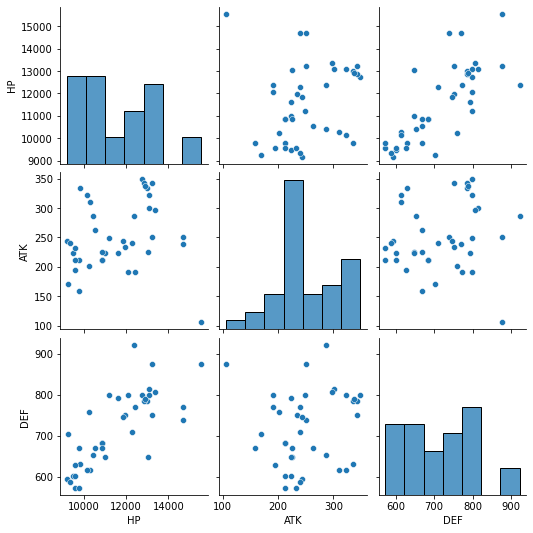

In [18]:
sns.pairplot(df_base_stats)

In [19]:
# Small dataset, only 410
df.size

410

In [20]:
# I will run use a RandomForestRegressor model for predicting results
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 1)

In [21]:
# I want to predict HP based on ATK and DEF
from sklearn.model_selection import train_test_split

y = df_base_stats.HP
X = df_base_stats.drop(['HP'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [22]:
# Fit the model on the training data
model.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [23]:
from sklearn.metrics import mean_absolute_error

pred_test = model.predict(X_test)
print(mean_absolute_error(pred_test, y_test))

1023.4388888888885


In [33]:
# The STD for HP is: 1674.877666
1023 / 1674.877666

0.6107908779052285

The Result is less than a full standard deviation from HP's mean.

In [24]:
df_base_stats.head()

,HP,ATK,DEF
0,9461,223,601
1,9787,159,669
2,13050,225,648
3,12397,191,771
4,10984,223,648


## Thoughts
The MAE looks high. I reviewed my notes and it looks like I can `preprocess` the data. 

In [25]:
# Preprocessing and refitting
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [26]:
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=1)

In [27]:
# Scaling caused it to perform worse
pred_test2 = model.predict(X_test)
print(mean_absolute_error(pred_test2, y_test))

1646.0755555555554


The scaled result is nearly 1 whole STD: 1674.877666

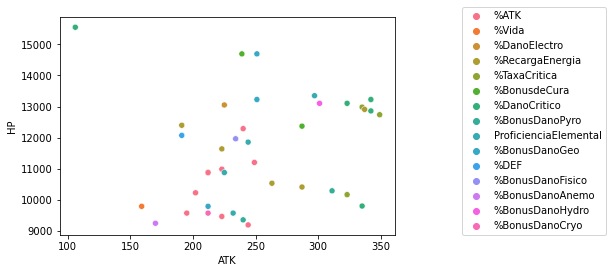

In [28]:
# There is a crazy outliter for low attack and high HP that is likely skewing my results
sns.scatterplot(data=df, x="ATK", y="HP", hue="Attribute")
plt.legend(loc=(1.2, 0))

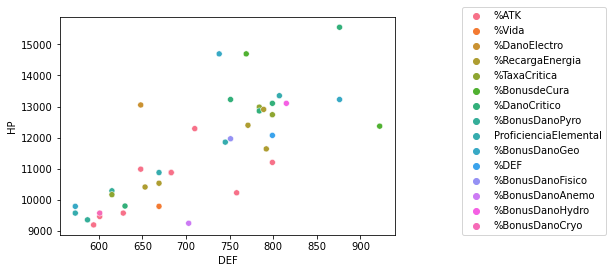

In [29]:
sns.scatterplot(data=df, x="DEF", y="HP", hue="Attribute")
plt.legend(loc=(1.2, 0))

In [30]:
# We'll try linear regression with just DEF -> HP
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [31]:
lin_pred = lin_model.predict(X_test)

In [32]:
print(mean_absolute_error(lin_pred, y_test))

884.918435414869


In [34]:
# Comparing linear regression result to standard deviate of HP
884.91 / 1674.877666

0.5283430652659977

Half a standard deviation away from the mean. Initially when I looked a the value I thought it performed **much** better than the random forest, but when comparing these results to the STD they actually are pretty similar.

## Linear Regression Results
The linear regression for `DEF -> HP` performed better than my random forest regression using the features `ATK` and `DEF`, but not majorly when considering the standard deviation of `HP`.